In [93]:
! pip install -r requirements.txt --quiet

# Multi-Agent Orchestration with Subgraphs

This notebook showcases a multi-agent pattern using **subgraphs** to encapsulate agent workflows into independent, reusable components.

- Build modular agent workflows that can be composed and orchestrated across complex systems.
- Enable better maintainability and scalability by separating concerns into distinct subgraphs.
- Demonstrates how to use a custom subgraph builder (`langchain_06b_subgraph_builder.py`) to easily construct child agents.

Subgraphs make it easier to manage, reuse, and evolve your agent architectures over time.

🔗 [Subgraphs in LangGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#subgraphs)


In [1]:
from dotenv import load_dotenv
from os import environ
from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict,Literal
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from  user_tools import get_weather_tool
from user_functions import vector_search  
from utils import pretty_print_messages
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

import requests
import json

load_dotenv(override=True)


True

## Subgraph: Interfece with Data Center Data (RAG and Endpoints)

In [2]:
from langchain_06b_subgraph_builder import SubgraphBuilder

llm = AzureChatOpenAI(
    temperature=0,
    azure_deployment=environ["AZURE_OPENAI_MODEL"],
    api_version=environ["AZURE_OPENAI_API_VERSION"],
)

builder = SubgraphBuilder(llm)
subgraph_datacenter = builder.build()

# Build Parent Graph to leverage Data Center Graph when needed

In [3]:
members = ["weather" , "datacenter"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.")

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

In [4]:

llm_with_tools = create_react_agent(llm, tools=[get_weather_tool])


In [5]:



def weather(state: MessagesState) -> Command[Literal["supervisor"]]:
    
    result = llm_with_tools.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="weather")
            ]
        },
        goto="supervisor",
    )

def supervisor(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [6]:

builder = StateGraph(MessagesState)

builder = StateGraph(MessagesState)
builder.add_node("weather", weather)
builder.add_node("datacenter", subgraph_datacenter)
builder.add_node("supervisor", supervisor)

builder.set_entry_point("supervisor")

graph = builder.compile()


In [12]:
graph.get_graph(xray=1)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None), 'weather:__start__': Node(id='weather:__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'weather:agent': Node(id='weather:agent', name='agent', data=call_model(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={}), metadata=None), 'weather:tools': Node(id='weather:tools', name='tools', data=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'get_weather_tool': StructuredTool(name='get_weather_tool', description='Call to get the current weather.', args_schema=<class 'langchain_core.utils.

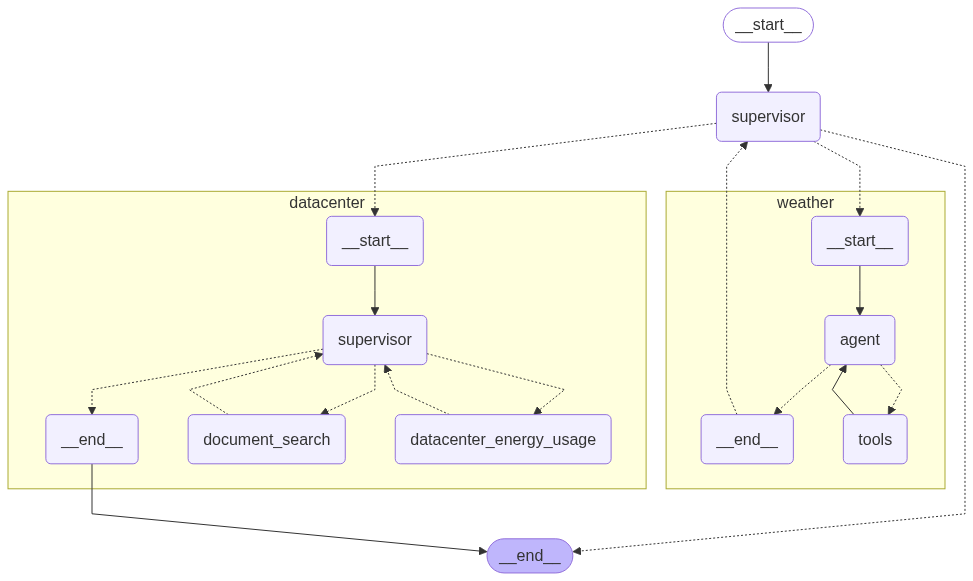

In [11]:
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    print("⚠️ Unable to display the graph visualization. This won't affect the rest of the notebook.")
    print(f"Reason: {e}")

In [8]:
for step in graph.stream({"messages": [{"role": "user", "content": "What data centers are in 'critical'?"}]}):
   pretty_print_messages(step)

Update from node supervisor:






> Entering new AgentExecutor chain...
Action: api_planner  
Action Input: I need to find the right API calls to retrieve data centers with a status of 'critical'.  
Observation: Plan:  
1. Use the GET /usage/energy-usage endpoint with a query parameter `alarm_status=critical` to retrieve energy usage data for data centers with a status of 'critical'.  

Explanation: This API call filters energy usage data by the `alarm_status` field, allowing us to retrieve only the data centers with a critical status.
Thought:I am ready to execute the API call to retrieve data centers with a status of 'critical'.  
Action: api_controller  
Action Input: GET /usage/energy-usage with query parameter `alarm_status=critical`  

> Entering new AgentExecutor chain...
Thought: I need to retrieve energy usage data for data centers where the alarm status is "critical". I will use the `requests_get` tool to execute the GET request with the specified query parameter.

Action: r

In [9]:
for step in graph.stream({"messages": [{"role": "user", "content": "What are the Data Center Space Types?"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node datacenter:


================================ Human Message =================================

What are the Data Center Space Types?
================================ System Message ================================

You are a helpful assistant. Use only the information in the context below to answer the user's question. If the context does not contain the answer, respond with "I don't know."

Context:
[lbnl-2024-united-states-data-center-energy-usage-report.pdf - Page 36]: 2024 United States Data Center Energy Usage Report 36 
Table 4.1.  Data Center Space Types Considered in This Study 
Space Type 
Description 
Telco Edge 
Deployment of small closets/rooms to micro data centers 
and network infrastructure by communications companies 
as points of presence throughout their network 
Commercial Edge 
Network closets, server rooms, and micro-data centers 
deployed to support modern digital, infrastructure, and 
software delivery services t

In [10]:
for step in graph.stream({"messages": [{"role": "user", "content": "what is the weather in sf"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node weather:


================================ Human Message =================================
Name: weather

The weather in San Francisco is currently 60°F and foggy.


Update from node supervisor:




